# Trabajo Práctico 2: Reseñas de Películas - XGBoost

## Grupo 11 - "Los Outliers"

- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_palette('colorblind')

Para este modelo probamos con diferentes técnicas de preprocesamiento y feature engineering, como por ejemplo, contar la cantidad de signos de exclamación, negaciones y adjetivos negativos en cada crítica, como el que utilizamos con Random Forest. Sin embargo al final terminamos obteniendo mejores resultados con los datasets más sencillos.

In [2]:
df = pd.read_csv('../datasets/train-simple.csv', index_col=0)
df.head()

,texto_preprocesado,lang,sentimiento
ID,,,
0,critico mencionar oz episodio estar enganchado...,es,positivo
1,pequén pequén produccion tecnica filmacion inc...,es,positivo
2,pense maravilloso pasar tiempo semana verano c...,es,positivo
3,basicamente familia nino pequeno jake pensar z...,es,negativo
4,amor tiempo petter mattei pelicula visualmente...,es,positivo


Vamos a dividir el dataset en tres partes: training, validation y test, para así poder evaluar utilizar los conjuntos de validación durante el entrenamiento del XGBoost utilizando early stopping para evitar el overfitting. En este caso hacemos el stratify considerando tanto el idioma de la crítica como el sentimiento, para que de esta forma haya igual proporción de críticas en inglés en los tres conjuntos, así como también una igual proporción de críticas positivas y negativas en este idioma.

In [3]:
df['lang+sentimiento'] = df['lang'].astype(str) + df['sentimiento'].astype(str)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['texto_preprocesado', 'lang+sentimiento']],
                                                    df['sentimiento'],
                                                    stratify=df['lang+sentimiento'],
                                                    test_size=.2,
                                                    random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train['texto_preprocesado'],
                                                      y_train,
                                                      stratify=X_train['lang+sentimiento'],
                                                      test_size=.2,
                                                      random_state=1)

X_test = X_test['texto_preprocesado']

Para este modelo probamos tres técnicas de tokenización y vectorización distintas: BoW, TF-IDF e hicimos un intento por utilizar embeddings preentrenadas a través del modelo [word2vec de la librería gensim](https://radimrehurek.com/gensim/models/word2vec.html). Sin embargo, con este último modelo el entrenamiento del modelo dilataba demasiado tiempo, por lo que desistimos en este intento. Entre los dos primeros métodos optimos por TF-IDF, ya que fué el que arrojó mejores resultados con los parámetros seleccionados.

Notamos que mientras más incrementabamos la cantidad de ngramas, más overfitting experimentaba el modelo, debido a que aumentaba significativamente la complejidad del mismo. También incrementaba mucho el tiempo de entrenamiento.

También convertimos las etiquetas a números ya que el modelo XGBoost solo puede trabajar con datos numéricos.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=10)
encoder = LabelEncoder()

X_train_trans = vectorizer.fit_transform(X_train)
X_valid_trans = vectorizer.transform(X_valid)
X_test_trans = vectorizer.transform(X_test)

y_train_trans = encoder.fit_transform(y_train)
y_valid_trans = encoder.transform(y_valid)
y_test_trans = encoder.transform(y_test)

## Entrenamiento

En el caso de los hiperparámetros del modelo, utilizando grid search logramos acotar la búsqueda de los hiperparámetros al rango de valores que daba los mejores resultados. Finalmente tomamos los mejores modelos y terminamos llegando al siguiente conjunto de hiperparámetros:

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=500,
                    learning_rate=0.3,
                    reg_alpha=0.2,
                    reg_lambda=0.2,
                    gamma=4,
                    max_depth=2,
                    n_jobs=-1,
                    objective='binary:logistic')

xgb.fit(X_train_trans, y_train_trans, eval_set=[(X_valid_trans, y_valid_trans)])

In [ ]:
xgb

Al incrementar la cantidad de estimadores y reducir la profundidad de los mismos logramos reducir significativamente los niveles de overfitting que mostraban los primeros modelos candidatos arrojados por el grid search. Así mismo, la inclusión de los parámetros de regularización alpha, lambda y gamma ayudó a combatir este mismo problema. El valor del learning rate fue ajustado constantemente y finalmente el elegido resultó dar un buen balance entre velocidad de entrenamiento, evitar que el mismo sufriera de "graddient exploding" y prevenir el underfitting.

## Evaluación

Finalmente, las métricas del que resultó ser el mejor modelo en los tres conjuntos fueron las siguientes:

In [ ]:
from sklearn.metrics import classification_report

y_train_pred = xgb.predict(X_train_trans)
print(classification_report(y_train_trans, y_train_pred))

In [ ]:
y_valid_pred = xgb.predict(X_valid_trans)
print(classification_report(y_valid_trans, y_valid_pred))

In [ ]:
y_test_pred = xgb.predict(X_test_trans)
print(classification_report(y_test_trans, y_test_pred))

En base a los resultados del modelo frente a datos que no ha visto antes podemos llegar a concluir que el modelo hace un buen trabajo evitando el overfitting excesivo. Las métricas son altas y relativamente cercanas a los resultados obtenidos en el mismo dataset en el que fue entrenado, por lo que consideramos que esta versión del modelo a la que llegamos hace un buen trabajo generalizando.

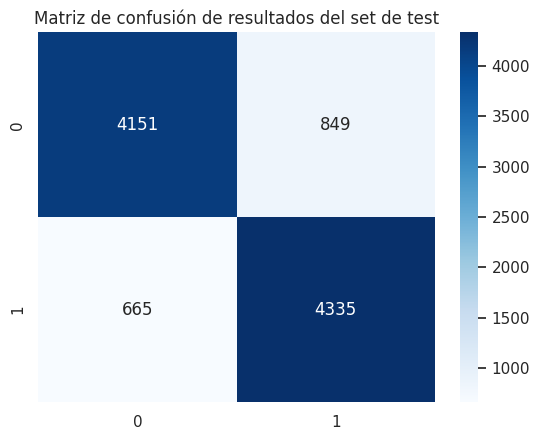

In [12]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test_trans, y_test_pred), cmap='Blues', annot=True, fmt='g').set(title='Matriz de confusión de resultados del set de test')
plt.show()

La matriz de confusión de los resultados sobre el conjunto de test verifican nuestra idea de que el modelo tiene buen desempeño por la poca cantidad de falsos positivos y falsos negativos.

## Predicciones

Hacemos las predicciones para subir a la competencia de Kaggle.

In [15]:
kaggle_df = pd.read_csv('../datasets/test-simple.csv', index_col=0)
kaggle_df['sentimiento'] = encoder.inverse_transform(xgb.predict(vectorizer.transform(kaggle_df['texto_preprocesado'])))

In [16]:
kaggle_df['sentimiento']

ID
60000    negativo
60001    negativo
60002    negativo
60003    negativo
60004    positivo
           ...   
68594    positivo
68595    negativo
68596    positivo
68597    negativo
68598    negativo
Name: sentimiento, Length: 8598, dtype: object

In [17]:
kaggle_df['sentimiento'].to_csv('../predicciones/xgboost-final.csv')

## Guardado del Modelo

Exportamos el modelo para que pueda ser utilizado nuevamente sin necesidad de ser re-entrenado.

In [18]:
from joblib import dump

dump(xgb, '../modelos/xgboost.joblib', compress=True)

['../modelos/xgboost.joblib']